**Goal:**:The goal of kinship verification is to determine whether a pair of faces are blood relatives or not. This task has seen lots of attention, which mainly focus on parent-child pair-wise types-- father-daughter (F-D), father-son (F-S), mother-daughter (M-D), mother-son (M-S)-- though some have also focused on siblings pairs-- brother-brother (B-B), sister-sister (S-S). This data supports all prior pair-wise types in sets much larger than previously offered to the research community. In addition, we introduce grandparent-grandchild pairs for the first time-- grandfather-granddaughter (GF-GD), grandfather-grandson (GF-GS),  grandmother-granddaughter (GM-GD), grandmother-grandson (GM-GS). As stated on the results page, our top performing benchmark scored an average accuracy of about 71%, so not only is there room for improvement, but also a need for more reliable systems before such technology is employed for practical purposes.

**Scope:**:Kinship verification has the potential to improve social media tagging, ancestry/genealogy site suggestions, along with many other applications in technology and media.


Skills/Technology to be used:: We will use deep neural networks and transfer learning techniques to train a neural network that will predict if two people are blood related or not given a picture of their face.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys

from glob import glob
from PIL import Image

In [2]:
np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE=64
NUMBER_EPOCHS=100
IMG_SIZE=100

In [3]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()

In [4]:
#F09xx are used for validation.
val_famillies = "F09"

#An example of data:"../input/train/F00002/MID1/P0001_face1.jpg"
all_images = glob("../input/train/*/*/*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)#Put the link of each picture under the key word of a person such as "F0002/MID1"
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
relationships = pd.read_csv("../input/train_relationships.csv")
relationships = list(zip(relationships.p1.values, relationships.p2.values))#For a List like[p1 p2], zip can return a result like [(p1[0],p2[0]),(p1[1],p2[1]),...]
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]#filter unused relationships


In [5]:
train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(train))    
print("Total val pairs:", len(val))    

Total train pairs: 3066
Total val pairs: 296


In [6]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.relationships = relationships #choose either train or val dataset to use
        self.transform = transform
        
    def __getitem__(self,index):
        img0_info = self.relationships[index][0]#for each relationship in train_relationships.csv, the first img comes from first row, and the second is either specially choosed related person or randomly choosed non-related person
        img0_path = glob("../input/train/"+img0_info+"/*.jpg")
        img0_path = random.choice(img0_path)
        
        cand_relationships = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info]#found all candidates related to person in img0
        if cand_relationships==[]:#in case no relationship is mensioned. But it is useless here because I choose the first person line by line.
            should_get_same_class = 0
        else:
            should_get_same_class = random.randint(0,1) 

        if should_get_same_class==1:#1 means related, and 0 means non-related.
            img1_info = random.choice(cand_relationships)#choose the second person from related relationships
            
            if img1_info[0]!=img0_info:
                img1_info=img1_info[0]
            else:
                img1_info=img1_info[1]
            img1_path = glob("../input/train/"+img1_info+"/*.jpg")#randomly choose a img of this person
            img1_path = random.choice(img1_path)
        else:#0 means non-related
            randChoose = True#in case the chosen person is related to first person
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]
                img1_info = img1_path.split("/")[-3] + "/" + img1_path.split("/")[-2]
                randChoose = False
                for x in cand_relationships:#if so, randomly choose another person
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break
                    
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        
        if self.transform is not None:#I think the transform is essential if you want to use GPU, because you have to trans data to tensor first.
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
            return img0, img1 , should_get_same_class #the returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
    
    def __len__(self):
        return len(self.relationships)#essential for choose the num of data in one epoch

In [7]:
folder_dataset = dset.ImageFolder(root='../input/train')

trainset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=train,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=BATCH_SIZE)
valset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=val,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)

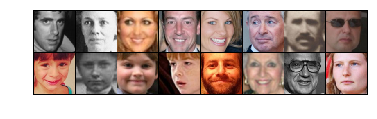

[0 1 0 1 1 1 1 1]


In [8]:
#only for visualize data in dataloader, it won't matters if you delete this block.
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #self.cnn1 = models.resnet50(pretrained=True)#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        #self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)
        
    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

Epoch： 0  start.
Epoch number 0
 Current loss 0.6931360363960266

Epoch number 0
 Current loss 0.6907700300216675

Epoch number 0
 Current loss 0.7367304563522339

Epoch number 0
 Current loss 0.725392758846283

Epoch number 0
 Current loss 0.6771450638771057

Accuracy of the network on the 296 val pairs in F09 : 57 %


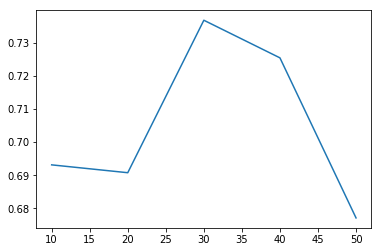

Epoch： 1  start.
Epoch number 1
 Current loss 0.7189218997955322

Epoch number 1
 Current loss 0.7380818128585815

Epoch number 1
 Current loss 0.7215436100959778

Epoch number 1
 Current loss 0.6684053540229797

Epoch number 1
 Current loss 0.6979498863220215

Accuracy of the network on the 296 val pairs in F09 : 53 %


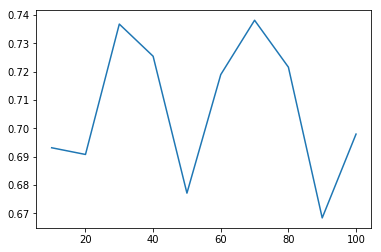

Epoch： 2  start.
Epoch number 2
 Current loss 0.6649951934814453

Epoch number 2
 Current loss 0.6276673078536987

Epoch number 2
 Current loss 0.6623950004577637

Epoch number 2
 Current loss 0.6491361856460571

Epoch number 2
 Current loss 0.6884219646453857

Accuracy of the network on the 296 val pairs in F09 : 58 %


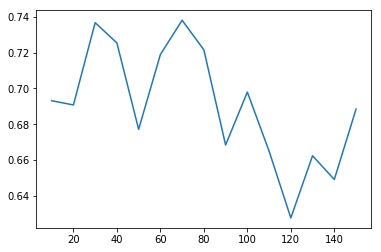

Epoch： 3  start.
Epoch number 3
 Current loss 0.6187070608139038

Epoch number 3
 Current loss 0.6884912848472595

Epoch number 3
 Current loss 0.6650452613830566

Epoch number 3
 Current loss 0.6478911638259888

Epoch number 3
 Current loss 0.6765815019607544

Accuracy of the network on the 296 val pairs in F09 : 57 %


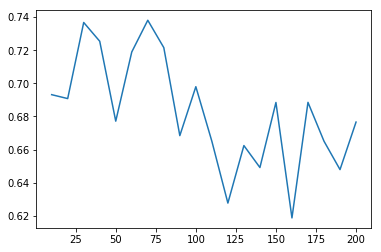

Epoch： 4  start.
Epoch number 4
 Current loss 0.6699520945549011

Epoch number 4
 Current loss 0.6770731210708618

Epoch number 4
 Current loss 0.6390902996063232

Epoch number 4
 Current loss 0.6601859927177429

Epoch number 4
 Current loss 0.6736600399017334

Accuracy of the network on the 296 val pairs in F09 : 58 %


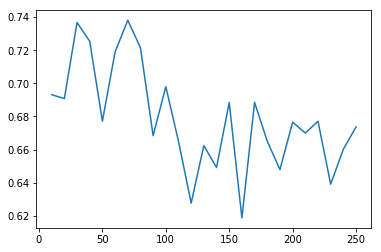

Epoch： 5  start.
Epoch number 5
 Current loss 0.6573577523231506

Epoch number 5
 Current loss 0.6291624903678894

Epoch number 5
 Current loss 0.6505369544029236

Epoch number 5
 Current loss 0.6418025493621826

Epoch number 5
 Current loss 0.6570444107055664

Accuracy of the network on the 296 val pairs in F09 : 61 %


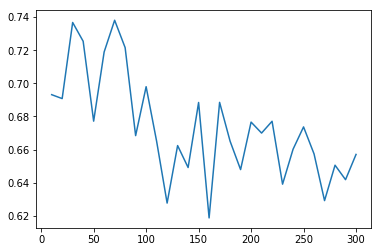

Epoch： 6  start.
Epoch number 6
 Current loss 0.641485869884491

Epoch number 6
 Current loss 0.6337078213691711

Epoch number 6
 Current loss 0.667027473449707

Epoch number 6
 Current loss 0.6083903908729553

Epoch number 6
 Current loss 0.6059755682945251

Accuracy of the network on the 296 val pairs in F09 : 64 %


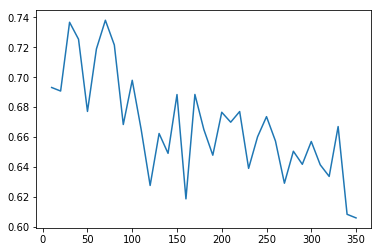

Epoch： 7  start.
Epoch number 7
 Current loss 0.675507128238678

Epoch number 7
 Current loss 0.661302387714386

Epoch number 7
 Current loss 0.6073302626609802

Epoch number 7
 Current loss 0.6223220229148865

Epoch number 7
 Current loss 0.6148884892463684

Accuracy of the network on the 296 val pairs in F09 : 57 %


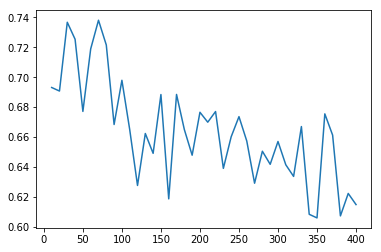

Epoch： 8  start.
Epoch number 8
 Current loss 0.5771538019180298

Epoch number 8
 Current loss 0.6755517721176147

Epoch number 8
 Current loss 0.7016911506652832

Epoch number 8
 Current loss 0.6283314228057861

Epoch number 8
 Current loss 0.6546796560287476

Accuracy of the network on the 296 val pairs in F09 : 56 %


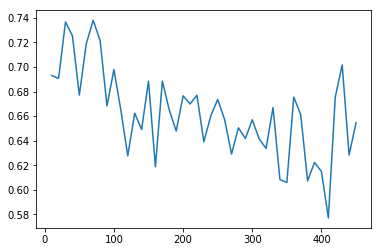

Epoch： 9  start.
Epoch number 9
 Current loss 0.6338443756103516

Epoch number 9
 Current loss 0.6754714250564575

Epoch number 9
 Current loss 0.6008557677268982

Epoch number 9
 Current loss 0.6138747930526733

Epoch number 9
 Current loss 0.7403031587600708

Accuracy of the network on the 296 val pairs in F09 : 62 %


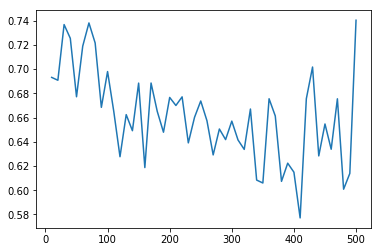

Epoch： 10  start.
Epoch number 10
 Current loss 0.590503454208374

Epoch number 10
 Current loss 0.7018044590950012

Epoch number 10
 Current loss 0.6712123155593872

Epoch number 10
 Current loss 0.738873302936554

Epoch number 10
 Current loss 0.6587436199188232

Accuracy of the network on the 296 val pairs in F09 : 60 %


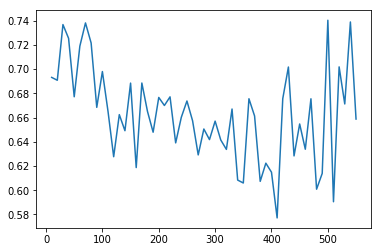

Epoch： 11  start.
Epoch number 11
 Current loss 0.6558143496513367

Epoch number 11
 Current loss 0.6297900080680847

Epoch number 11
 Current loss 0.6531801223754883

Epoch number 11
 Current loss 0.611051082611084

Epoch number 11
 Current loss 0.6232667565345764

Accuracy of the network on the 296 val pairs in F09 : 62 %


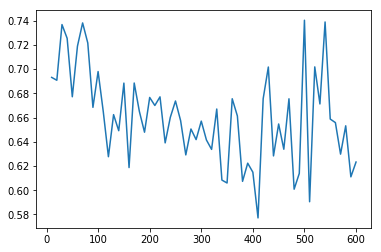

Epoch： 12  start.
Epoch number 12
 Current loss 0.6836243271827698

Epoch number 12
 Current loss 0.6615867614746094

Epoch number 12
 Current loss 0.7171161770820618

Epoch number 12
 Current loss 0.6379033923149109

Epoch number 12
 Current loss 0.6625301837921143

Accuracy of the network on the 296 val pairs in F09 : 57 %


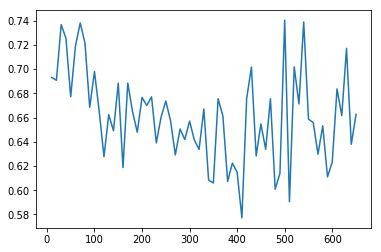

Epoch： 13  start.
Epoch number 13
 Current loss 0.6806620359420776

Epoch number 13
 Current loss 0.6180025935173035

Epoch number 13
 Current loss 0.5905883312225342

Epoch number 13
 Current loss 0.6491913199424744

Epoch number 13
 Current loss 0.6929974555969238

Accuracy of the network on the 296 val pairs in F09 : 58 %


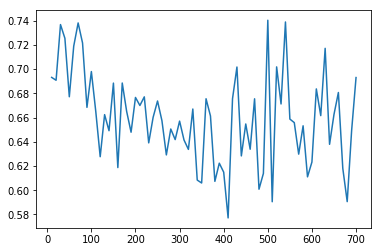

Epoch： 14  start.
Epoch number 14
 Current loss 0.6771616339683533

Epoch number 14
 Current loss 0.623288631439209

Epoch number 14
 Current loss 0.5886666178703308

Epoch number 14
 Current loss 0.6189337372779846

Epoch number 14
 Current loss 0.7184086441993713

Accuracy of the network on the 296 val pairs in F09 : 62 %


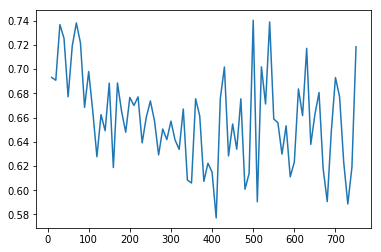

Epoch： 15  start.
Epoch number 15
 Current loss 0.7027280926704407

Epoch number 15
 Current loss 0.6837356686592102

Epoch number 15
 Current loss 0.5849176049232483

Epoch number 15
 Current loss 0.6524906754493713

Epoch number 15
 Current loss 0.5953001976013184

Accuracy of the network on the 296 val pairs in F09 : 58 %


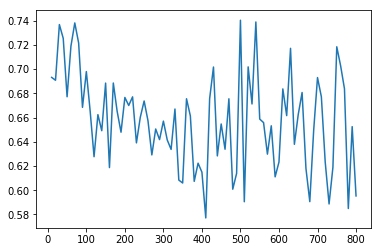

Epoch： 16  start.
Epoch number 16
 Current loss 0.6764447093009949

Epoch number 16
 Current loss 0.6047562956809998

Epoch number 16
 Current loss 0.5634552836418152

Epoch number 16
 Current loss 0.6123554706573486

Epoch number 16
 Current loss 0.5828280448913574

Accuracy of the network on the 296 val pairs in F09 : 56 %


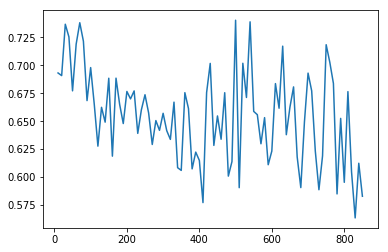

Epoch： 17  start.
Epoch number 17
 Current loss 0.5415924191474915

Epoch number 17
 Current loss 0.6568319797515869

Epoch number 17
 Current loss 0.6185510754585266

Epoch number 17
 Current loss 0.6108472347259521

Epoch number 17
 Current loss 0.6521033644676208

Accuracy of the network on the 296 val pairs in F09 : 62 %


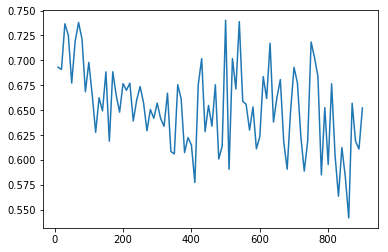

Epoch： 18  start.
Epoch number 18
 Current loss 0.6810827255249023

Epoch number 18
 Current loss 0.6417126655578613

Epoch number 18
 Current loss 0.6612308025360107

Epoch number 18
 Current loss 0.6356830596923828

Epoch number 18
 Current loss 0.6086649298667908

Accuracy of the network on the 296 val pairs in F09 : 53 %


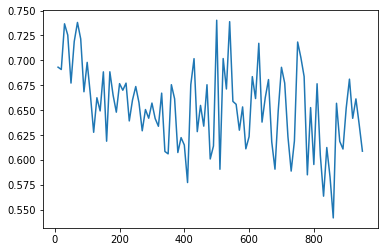

Epoch： 19  start.
Epoch number 19
 Current loss 0.6528686881065369

Epoch number 19
 Current loss 0.6235487461090088

Epoch number 19
 Current loss 0.6516836285591125

Epoch number 19
 Current loss 0.6946286559104919

Epoch number 19
 Current loss 0.5941422581672668

Accuracy of the network on the 296 val pairs in F09 : 63 %


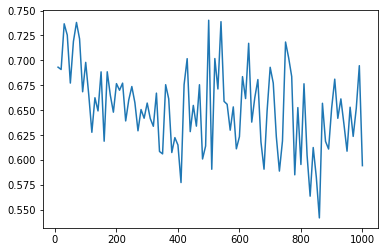

Epoch： 20  start.
Epoch number 20
 Current loss 0.5840553045272827

Epoch number 20
 Current loss 0.6004481911659241

Epoch number 20
 Current loss 0.5919014811515808

Epoch number 20
 Current loss 0.6587074398994446

Epoch number 20
 Current loss 0.618071973323822

Accuracy of the network on the 296 val pairs in F09 : 60 %


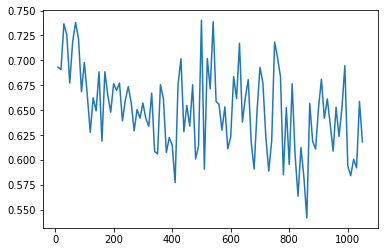

Epoch： 21  start.
Epoch number 21
 Current loss 0.6174412369728088

Epoch number 21
 Current loss 0.6616947650909424

Epoch number 21
 Current loss 0.6160428524017334

Epoch number 21
 Current loss 0.5709878206253052

Epoch number 21
 Current loss 0.5215226411819458

Accuracy of the network on the 296 val pairs in F09 : 63 %


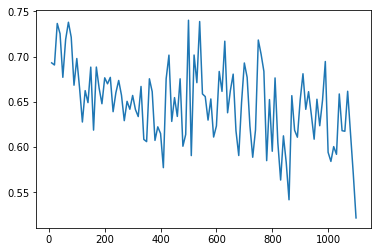

Epoch： 22  start.
Epoch number 22
 Current loss 0.672200083732605

Epoch number 22
 Current loss 0.5904624462127686

Epoch number 22
 Current loss 0.6178802847862244

Epoch number 22
 Current loss 0.6017352342605591

Epoch number 22
 Current loss 0.6364410519599915

Accuracy of the network on the 296 val pairs in F09 : 65 %


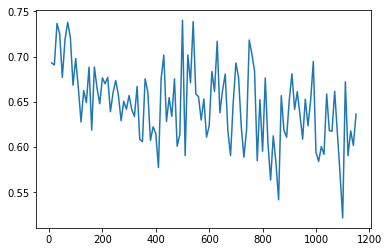

Epoch： 23  start.
Epoch number 23
 Current loss 0.611914873123169

Epoch number 23
 Current loss 0.585821807384491

Epoch number 23
 Current loss 0.6684495210647583

Epoch number 23
 Current loss 0.647705078125

Epoch number 23
 Current loss 0.6123169660568237

Accuracy of the network on the 296 val pairs in F09 : 65 %


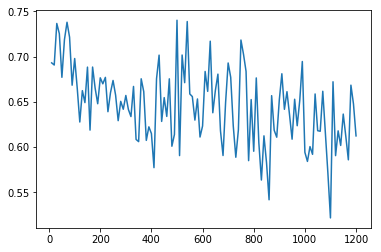

Epoch： 24  start.
Epoch number 24
 Current loss 0.5968731641769409

Epoch number 24
 Current loss 0.5222201347351074

Epoch number 24
 Current loss 0.6097722053527832

Epoch number 24
 Current loss 0.6118799448013306

Epoch number 24
 Current loss 0.5855938792228699

Accuracy of the network on the 296 val pairs in F09 : 60 %


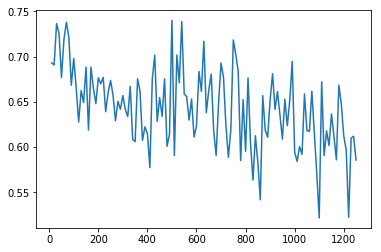

Epoch： 25  start.
Epoch number 25
 Current loss 0.5695383548736572

Epoch number 25
 Current loss 0.5952279567718506

Epoch number 25
 Current loss 0.5490322113037109

Epoch number 25
 Current loss 0.6604738831520081

Epoch number 25
 Current loss 0.6712351441383362

Accuracy of the network on the 296 val pairs in F09 : 60 %


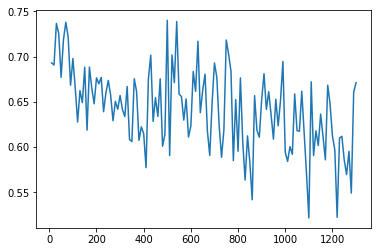

Epoch： 26  start.
Epoch number 26
 Current loss 0.6535546779632568

Epoch number 26
 Current loss 0.5421834588050842

Epoch number 26
 Current loss 0.5990918874740601

Epoch number 26
 Current loss 0.5807567238807678

Epoch number 26
 Current loss 0.6507614850997925

Accuracy of the network on the 296 val pairs in F09 : 58 %


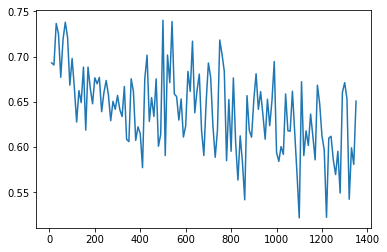

Epoch： 27  start.
Epoch number 27
 Current loss 0.6387273073196411

Epoch number 27
 Current loss 0.6498988270759583

Epoch number 27
 Current loss 0.6656293869018555

Epoch number 27
 Current loss 0.5251696109771729

Epoch number 27
 Current loss 0.6376019716262817

Accuracy of the network on the 296 val pairs in F09 : 62 %


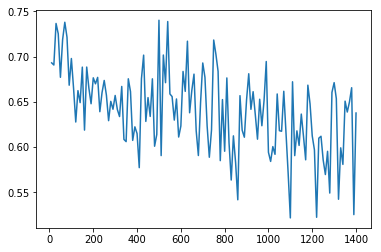

Epoch： 28  start.
Epoch number 28
 Current loss 0.6314443945884705

Epoch number 28
 Current loss 0.4798664152622223

Epoch number 28
 Current loss 0.6386282444000244

Epoch number 28
 Current loss 0.5424543619155884

Epoch number 28
 Current loss 0.5883245468139648

Accuracy of the network on the 296 val pairs in F09 : 63 %


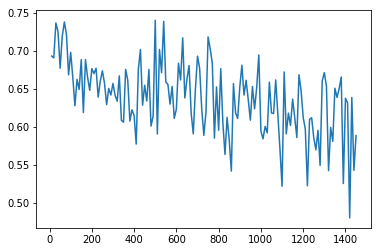

Epoch： 29  start.
Epoch number 29
 Current loss 0.5584061145782471

Epoch number 29
 Current loss 0.5774121284484863

Epoch number 29
 Current loss 0.5961112976074219

Epoch number 29
 Current loss 0.6161801218986511

Epoch number 29
 Current loss 0.5828658938407898

Accuracy of the network on the 296 val pairs in F09 : 60 %


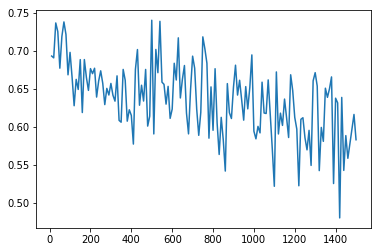

Epoch： 30  start.
Epoch number 30
 Current loss 0.5401853322982788

Epoch number 30
 Current loss 0.5789459943771362

Epoch number 30
 Current loss 0.6239322423934937

Epoch number 30
 Current loss 0.6519734859466553

Epoch number 30
 Current loss 0.542194664478302

Accuracy of the network on the 296 val pairs in F09 : 66 %


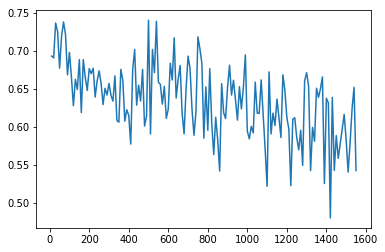

Epoch： 31  start.
Epoch number 31
 Current loss 0.5551053881645203

Epoch number 31
 Current loss 0.5586611032485962

Epoch number 31
 Current loss 0.5122900605201721

Epoch number 31
 Current loss 0.5557312965393066

Epoch number 31
 Current loss 0.6383368372917175

Accuracy of the network on the 296 val pairs in F09 : 63 %


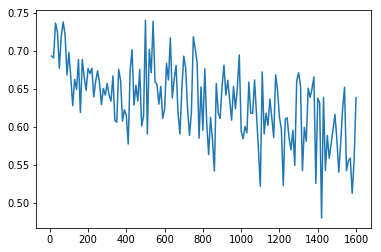

Epoch： 32  start.
Epoch number 32
 Current loss 0.5774664878845215

Epoch number 32
 Current loss 0.5254773497581482

Epoch number 32
 Current loss 0.5966782569885254

Epoch number 32
 Current loss 0.6504454612731934

Epoch number 32
 Current loss 0.5537684559822083

Accuracy of the network on the 296 val pairs in F09 : 56 %


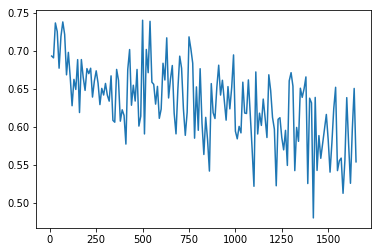

Epoch： 33  start.
Epoch number 33
 Current loss 0.5616968870162964

Epoch number 33
 Current loss 0.561601459980011

Epoch number 33
 Current loss 0.541928768157959

Epoch number 33
 Current loss 0.5284290313720703

Epoch number 33
 Current loss 0.5968833565711975

Accuracy of the network on the 296 val pairs in F09 : 59 %


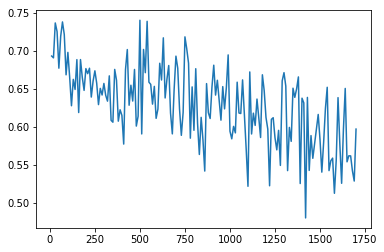

Epoch： 34  start.
Epoch number 34
 Current loss 0.5994512438774109

Epoch number 34
 Current loss 0.5968061685562134

Epoch number 34
 Current loss 0.6374472379684448

Epoch number 34
 Current loss 0.6237095594406128

Epoch number 34
 Current loss 0.7243651747703552

Accuracy of the network on the 296 val pairs in F09 : 57 %


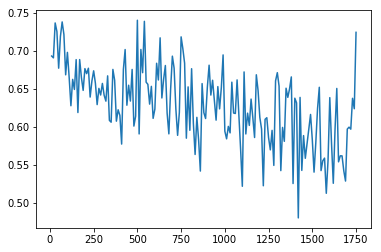

Epoch： 35  start.
Epoch number 35
 Current loss 0.554543137550354

Epoch number 35
 Current loss 0.6222748160362244

Epoch number 35
 Current loss 0.5426559448242188

Epoch number 35
 Current loss 0.537625789642334

Epoch number 35
 Current loss 0.629263699054718

Accuracy of the network on the 296 val pairs in F09 : 58 %


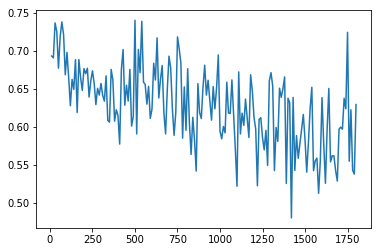

Epoch： 36  start.
Epoch number 36
 Current loss 0.6655813455581665

Epoch number 36
 Current loss 0.6337827444076538

Epoch number 36
 Current loss 0.5905017256736755

Epoch number 36
 Current loss 0.5894863605499268

Epoch number 36
 Current loss 0.5982803702354431

Accuracy of the network on the 296 val pairs in F09 : 63 %


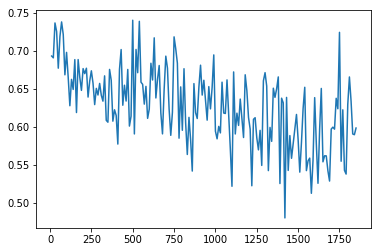

Epoch： 37  start.
Epoch number 37
 Current loss 0.5127558708190918

Epoch number 37
 Current loss 0.6043199896812439

Epoch number 37
 Current loss 0.5877084732055664

Epoch number 37
 Current loss 0.6520686149597168

Epoch number 37
 Current loss 0.4832175374031067

Accuracy of the network on the 296 val pairs in F09 : 58 %


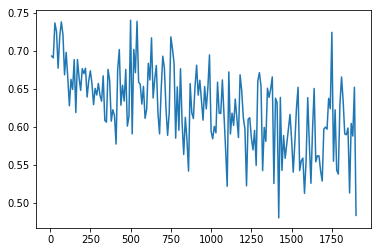

Epoch： 38  start.
Epoch number 38
 Current loss 0.6394246220588684

Epoch number 38
 Current loss 0.5215854048728943

Epoch number 38
 Current loss 0.7114161849021912

Epoch number 38
 Current loss 0.6656415462493896

Epoch number 38
 Current loss 0.5185481905937195

Accuracy of the network on the 296 val pairs in F09 : 64 %


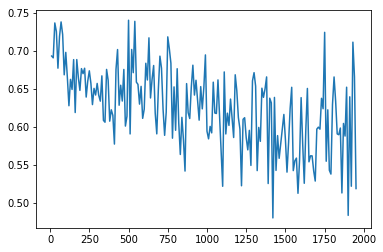

Epoch： 39  start.
Epoch number 39
 Current loss 0.6316254138946533

Epoch number 39
 Current loss 0.6155266165733337

Epoch number 39
 Current loss 0.4810900092124939

Epoch number 39
 Current loss 0.6458053588867188

Epoch number 39
 Current loss 0.5351601243019104

Accuracy of the network on the 296 val pairs in F09 : 60 %


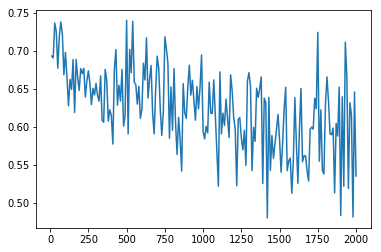

Epoch： 40  start.
Epoch number 40
 Current loss 0.5271776914596558

Epoch number 40
 Current loss 0.7072738409042358

Epoch number 40
 Current loss 0.4669574797153473

Epoch number 40
 Current loss 0.5225429534912109

Epoch number 40
 Current loss 0.5941256284713745

Accuracy of the network on the 296 val pairs in F09 : 64 %


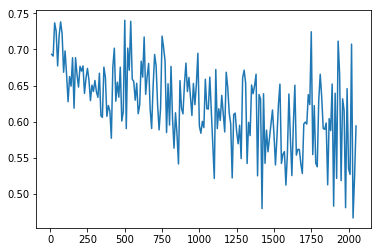

Epoch： 41  start.
Epoch number 41
 Current loss 0.6095057129859924

Epoch number 41
 Current loss 0.5195045471191406

Epoch number 41
 Current loss 0.5448974370956421

Epoch number 41
 Current loss 0.6624588966369629

Epoch number 41
 Current loss 0.603480875492096

Accuracy of the network on the 296 val pairs in F09 : 61 %


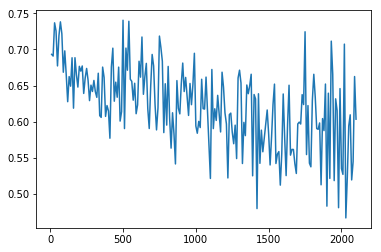

Epoch： 42  start.
Epoch number 42
 Current loss 0.5603345632553101

Epoch number 42
 Current loss 0.5922239422798157

Epoch number 42
 Current loss 0.5196256637573242

Epoch number 42
 Current loss 0.47383323311805725

Epoch number 42
 Current loss 0.5658491849899292

Accuracy of the network on the 296 val pairs in F09 : 56 %


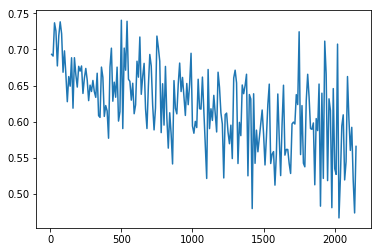

Epoch： 43  start.
Epoch number 43
 Current loss 0.5557743906974792

Epoch number 43
 Current loss 0.5794028043746948

Epoch number 43
 Current loss 0.6066555380821228

Epoch number 43
 Current loss 0.5626593232154846

Epoch number 43
 Current loss 0.46626508235931396

Accuracy of the network on the 296 val pairs in F09 : 58 %


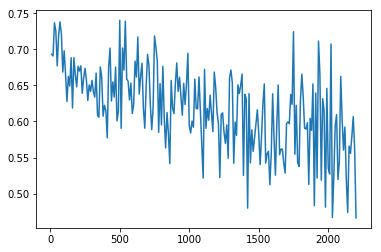

Epoch： 44  start.
Epoch number 44
 Current loss 0.500806450843811

Epoch number 44
 Current loss 0.6007776260375977

Epoch number 44
 Current loss 0.6453781127929688

Epoch number 44
 Current loss 0.5252170562744141

Epoch number 44
 Current loss 0.6035245060920715

Accuracy of the network on the 296 val pairs in F09 : 59 %


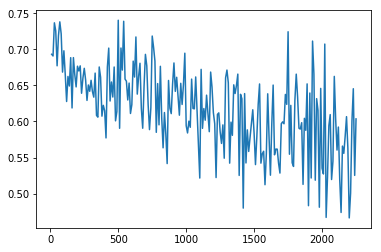

Epoch： 45  start.
Epoch number 45
 Current loss 0.49397024512290955

Epoch number 45
 Current loss 0.5083920359611511

Epoch number 45
 Current loss 0.5060372352600098

Epoch number 45
 Current loss 0.5451850891113281

Epoch number 45
 Current loss 0.4604853391647339

Accuracy of the network on the 296 val pairs in F09 : 58 %


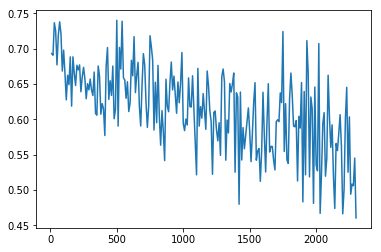

Epoch： 46  start.
Epoch number 46
 Current loss 0.5830841660499573

Epoch number 46
 Current loss 0.5709491968154907

Epoch number 46
 Current loss 0.6331403851509094

Epoch number 46
 Current loss 0.4264463782310486

Epoch number 46
 Current loss 0.5180509686470032

Accuracy of the network on the 296 val pairs in F09 : 63 %


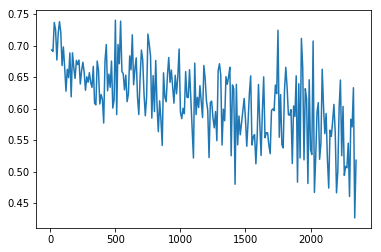

Epoch： 47  start.
Epoch number 47
 Current loss 0.5002061724662781

Epoch number 47
 Current loss 0.47514864802360535

Epoch number 47
 Current loss 0.5137704610824585

Epoch number 47
 Current loss 0.5555196404457092

Epoch number 47
 Current loss 0.5213598012924194

Accuracy of the network on the 296 val pairs in F09 : 52 %


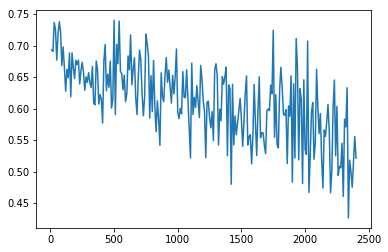

Epoch： 48  start.
Epoch number 48
 Current loss 0.5869721174240112

Epoch number 48
 Current loss 0.5599795579910278

Epoch number 48
 Current loss 0.4935000240802765

Epoch number 48
 Current loss 0.5330663919448853

Epoch number 48
 Current loss 0.47756338119506836

Accuracy of the network on the 296 val pairs in F09 : 55 %


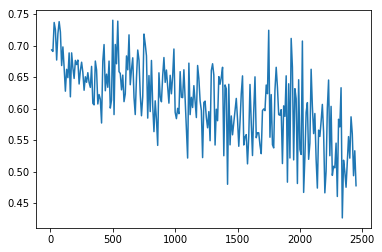

Epoch： 49  start.
Epoch number 49
 Current loss 0.5082932710647583

Epoch number 49
 Current loss 0.6325085163116455

Epoch number 49
 Current loss 0.5961443781852722

Epoch number 49
 Current loss 0.5919820070266724

Epoch number 49
 Current loss 0.5222306251525879

Accuracy of the network on the 296 val pairs in F09 : 63 %


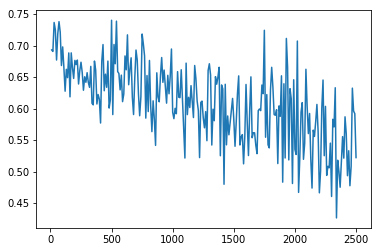

Epoch： 50  start.
Epoch number 50
 Current loss 0.6851584315299988

Epoch number 50
 Current loss 0.494039922952652

Epoch number 50
 Current loss 0.5704861283302307

Epoch number 50
 Current loss 0.5752480626106262

Epoch number 50
 Current loss 0.5879485011100769

Accuracy of the network on the 296 val pairs in F09 : 53 %


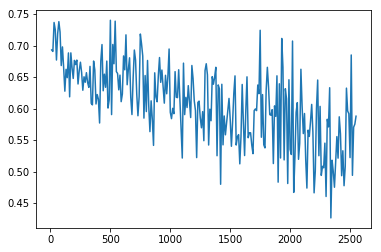

Epoch： 51  start.
Epoch number 51
 Current loss 0.6391445398330688

Epoch number 51
 Current loss 0.4607624411582947

Epoch number 51
 Current loss 0.562627375125885

Epoch number 51
 Current loss 0.5502431392669678

Epoch number 51
 Current loss 0.5589925050735474

Accuracy of the network on the 296 val pairs in F09 : 56 %


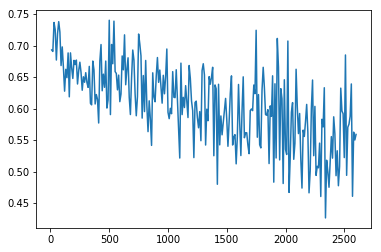

Epoch： 52  start.
Epoch number 52
 Current loss 0.48643216490745544

Epoch number 52
 Current loss 0.5663304924964905

Epoch number 52
 Current loss 0.6076672077178955

Epoch number 52
 Current loss 0.4924061596393585

Epoch number 52
 Current loss 0.5755891799926758

Accuracy of the network on the 296 val pairs in F09 : 56 %


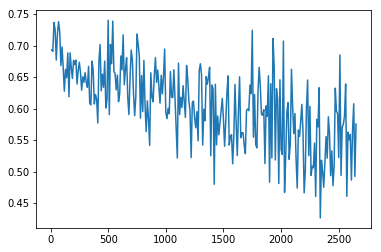

Epoch： 53  start.
Epoch number 53
 Current loss 0.524691104888916

Epoch number 53
 Current loss 0.521220326423645

Epoch number 53
 Current loss 0.5081559419631958

Epoch number 53
 Current loss 0.5460876822471619

Epoch number 53
 Current loss 0.4885951578617096

Accuracy of the network on the 296 val pairs in F09 : 62 %


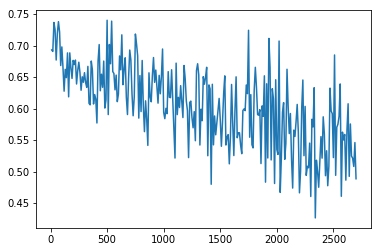

Epoch： 54  start.
Epoch number 54
 Current loss 0.5605688095092773

Epoch number 54
 Current loss 0.4922771155834198

Epoch number 54
 Current loss 0.5703592896461487

Epoch number 54
 Current loss 0.4983726739883423

Epoch number 54
 Current loss 0.506493330001831

Accuracy of the network on the 296 val pairs in F09 : 55 %


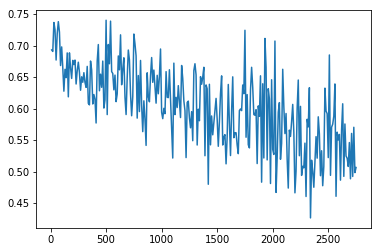

Epoch： 55  start.
Epoch number 55
 Current loss 0.4820880889892578

Epoch number 55
 Current loss 0.6023020148277283

Epoch number 55
 Current loss 0.5586362481117249

Epoch number 55
 Current loss 0.49749284982681274

Epoch number 55
 Current loss 0.543279767036438

Accuracy of the network on the 296 val pairs in F09 : 58 %


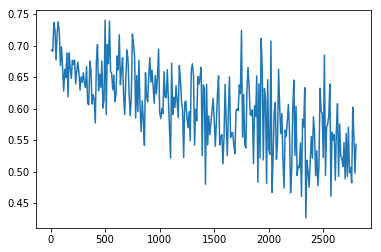

Epoch： 56  start.
Epoch number 56
 Current loss 0.4839077889919281

Epoch number 56
 Current loss 0.5664445161819458

Epoch number 56
 Current loss 0.5153986811637878

Epoch number 56
 Current loss 0.4372713565826416

Epoch number 56
 Current loss 0.4555445909500122

Accuracy of the network on the 296 val pairs in F09 : 59 %


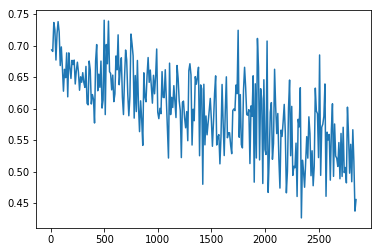

Epoch： 57  start.
Epoch number 57
 Current loss 0.49217548966407776

Epoch number 57
 Current loss 0.5676197409629822

Epoch number 57
 Current loss 0.4970949590206146

Epoch number 57
 Current loss 0.4879691004753113

Epoch number 57
 Current loss 0.4339678883552551

Accuracy of the network on the 296 val pairs in F09 : 59 %


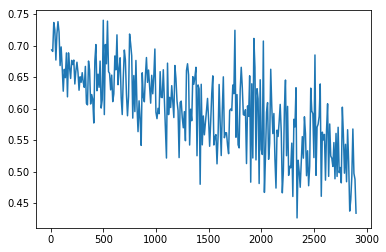

Epoch： 58  start.
Epoch number 58
 Current loss 0.4568312168121338

Epoch number 58
 Current loss 0.49673986434936523

Epoch number 58
 Current loss 0.5427863597869873

Epoch number 58
 Current loss 0.46115633845329285

Epoch number 58
 Current loss 0.5220758318901062

Accuracy of the network on the 296 val pairs in F09 : 59 %


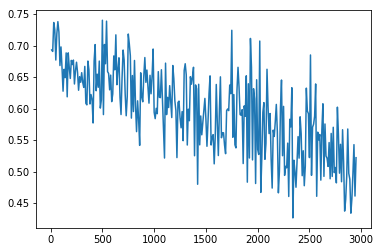

Epoch： 59  start.
Epoch number 59
 Current loss 0.49035272002220154

Epoch number 59
 Current loss 0.44439470767974854

Epoch number 59
 Current loss 0.6442264318466187

Epoch number 59
 Current loss 0.5550291538238525

Epoch number 59
 Current loss 0.5173492431640625

Accuracy of the network on the 296 val pairs in F09 : 55 %


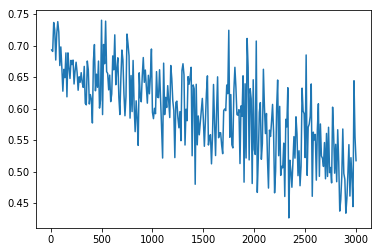

Epoch： 60  start.
Epoch number 60
 Current loss 0.6214057803153992

Epoch number 60
 Current loss 0.45154333114624023

Epoch number 60
 Current loss 0.5072128176689148

Epoch number 60
 Current loss 0.5548230409622192

Epoch number 60
 Current loss 0.5791743993759155

Accuracy of the network on the 296 val pairs in F09 : 61 %


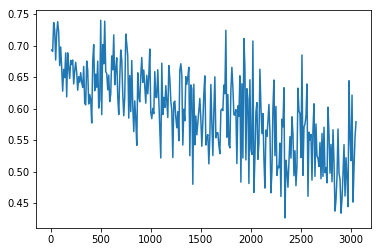

Epoch： 61  start.
Epoch number 61
 Current loss 0.5070195198059082

Epoch number 61
 Current loss 0.45322534441947937

Epoch number 61
 Current loss 0.5951953530311584

Epoch number 61
 Current loss 0.605797529220581

Epoch number 61
 Current loss 0.5926101207733154

Accuracy of the network on the 296 val pairs in F09 : 60 %


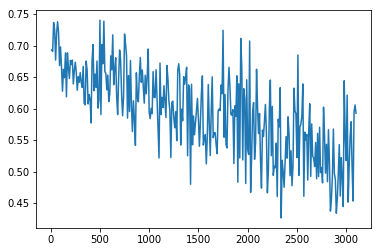

Epoch： 62  start.
Epoch number 62
 Current loss 0.5209985375404358

Epoch number 62
 Current loss 0.48245275020599365

Epoch number 62
 Current loss 0.5413669347763062

Epoch number 62
 Current loss 0.4992876350879669

Epoch number 62
 Current loss 0.47799134254455566

Accuracy of the network on the 296 val pairs in F09 : 61 %


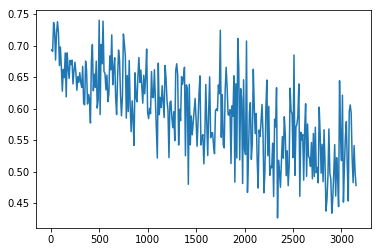

Epoch： 63  start.
Epoch number 63
 Current loss 0.534945547580719

Epoch number 63
 Current loss 0.5541862845420837

Epoch number 63
 Current loss 0.5355328321456909

Epoch number 63
 Current loss 0.49967899918556213

Epoch number 63
 Current loss 0.4951881170272827

Accuracy of the network on the 296 val pairs in F09 : 58 %


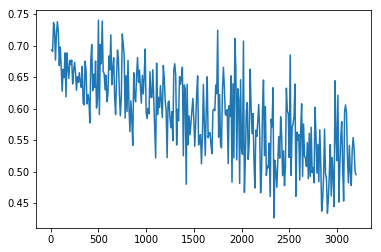

Epoch： 64  start.
Epoch number 64
 Current loss 0.41265493631362915

Epoch number 64
 Current loss 0.5646277070045471

Epoch number 64
 Current loss 0.5571399331092834

Epoch number 64
 Current loss 0.574849009513855

Epoch number 64
 Current loss 0.5798604488372803

Accuracy of the network on the 296 val pairs in F09 : 56 %


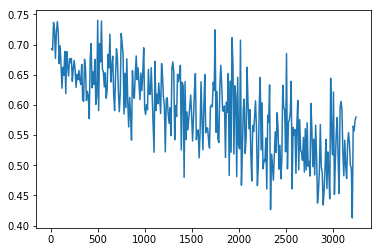

Epoch： 65  start.
Epoch number 65
 Current loss 0.42501598596572876

Epoch number 65
 Current loss 0.48687446117401123

Epoch number 65
 Current loss 0.5441929697990417

Epoch number 65
 Current loss 0.47226428985595703

Epoch number 65
 Current loss 0.4968756437301636

Accuracy of the network on the 296 val pairs in F09 : 61 %


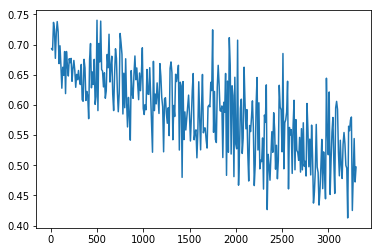

Epoch： 66  start.
Epoch number 66
 Current loss 0.3585103154182434

Epoch number 66
 Current loss 0.4800499379634857

Epoch number 66
 Current loss 0.49022939801216125

Epoch number 66
 Current loss 0.4812653064727783

Epoch number 66
 Current loss 0.48618096113204956

Accuracy of the network on the 296 val pairs in F09 : 57 %


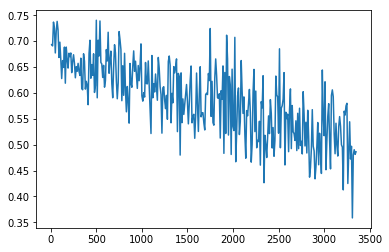

Epoch： 67  start.
Epoch number 67
 Current loss 0.5202896595001221

Epoch number 67
 Current loss 0.5564231276512146

Epoch number 67
 Current loss 0.44935402274131775

Epoch number 67
 Current loss 0.4108254611492157

Epoch number 67
 Current loss 0.5942169427871704

Accuracy of the network on the 296 val pairs in F09 : 60 %


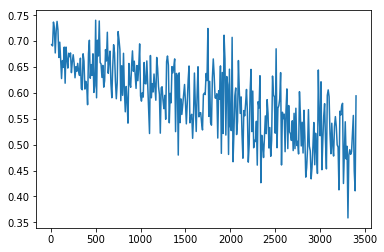

Epoch： 68  start.
Epoch number 68
 Current loss 0.4213363230228424

Epoch number 68
 Current loss 0.4167664647102356

Epoch number 68
 Current loss 0.5416485667228699

Epoch number 68
 Current loss 0.4967626631259918

Epoch number 68
 Current loss 0.4319450855255127

Accuracy of the network on the 296 val pairs in F09 : 49 %


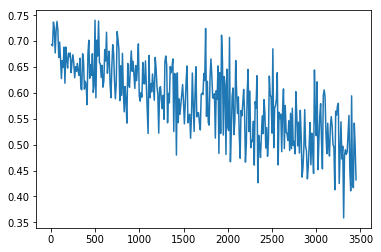

Epoch： 69  start.
Epoch number 69
 Current loss 0.4447961151599884

Epoch number 69
 Current loss 0.5716171860694885

Epoch number 69
 Current loss 0.4921826720237732

Epoch number 69
 Current loss 0.5532630085945129

Epoch number 69
 Current loss 0.498928964138031

Accuracy of the network on the 296 val pairs in F09 : 57 %


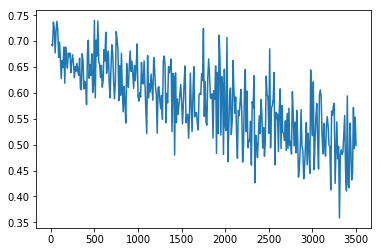

Epoch： 70  start.
Epoch number 70
 Current loss 0.5557696223258972

Epoch number 70
 Current loss 0.46997541189193726

Epoch number 70
 Current loss 0.4977327287197113

Epoch number 70
 Current loss 0.563952624797821

Epoch number 70
 Current loss 0.5651174187660217

Accuracy of the network on the 296 val pairs in F09 : 57 %


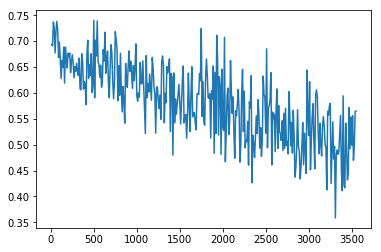

Epoch： 71  start.
Epoch number 71
 Current loss 0.5612621307373047

Epoch number 71
 Current loss 0.32376885414123535

Epoch number 71
 Current loss 0.3863014578819275

Epoch number 71
 Current loss 0.617439329624176

Epoch number 71
 Current loss 0.4924275279045105

Accuracy of the network on the 296 val pairs in F09 : 58 %


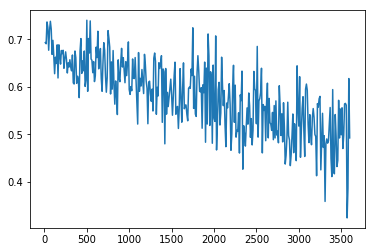

Epoch： 72  start.
Epoch number 72
 Current loss 0.48336562514305115

Epoch number 72
 Current loss 0.473591148853302

Epoch number 72
 Current loss 0.6586878299713135

Epoch number 72
 Current loss 0.4150368273258209

Epoch number 72
 Current loss 0.5015145540237427

Accuracy of the network on the 296 val pairs in F09 : 59 %


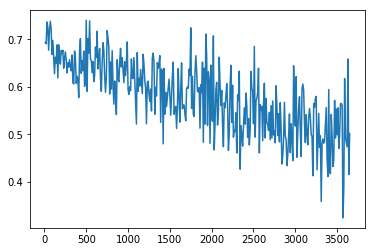

Epoch： 73  start.
Epoch number 73
 Current loss 0.4972807466983795

Epoch number 73
 Current loss 0.5038200616836548

Epoch number 73
 Current loss 0.5017609596252441

Epoch number 73
 Current loss 0.5621311068534851

Epoch number 73
 Current loss 0.5481317639350891

Accuracy of the network on the 296 val pairs in F09 : 51 %


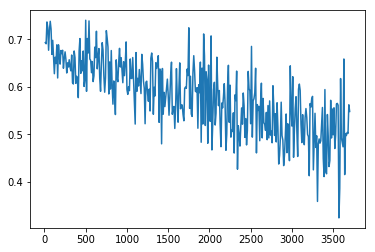

Epoch： 74  start.
Epoch number 74
 Current loss 0.4451759159564972

Epoch number 74
 Current loss 0.4774104952812195

Epoch number 74
 Current loss 0.5320667028427124

Epoch number 74
 Current loss 0.4148729145526886

Epoch number 74
 Current loss 0.5250212550163269

Accuracy of the network on the 296 val pairs in F09 : 53 %


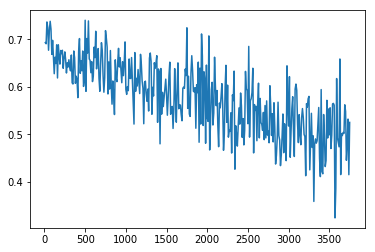

Epoch： 75  start.
Epoch number 75
 Current loss 0.5495641827583313

Epoch number 75
 Current loss 0.42792582511901855

Epoch number 75
 Current loss 0.4595189690589905

Epoch number 75
 Current loss 0.5754013657569885

Epoch number 75
 Current loss 0.429918497800827

Accuracy of the network on the 296 val pairs in F09 : 58 %


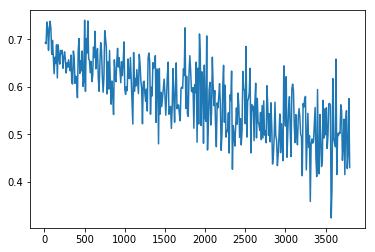

Epoch： 76  start.
Epoch number 76
 Current loss 0.5400022268295288

Epoch number 76
 Current loss 0.5115500688552856

Epoch number 76
 Current loss 0.5149874687194824

Epoch number 76
 Current loss 0.5526842474937439

Epoch number 76
 Current loss 0.442271888256073

Accuracy of the network on the 296 val pairs in F09 : 58 %


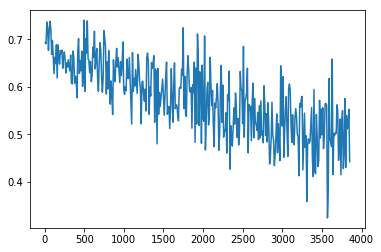

Epoch： 77  start.
Epoch number 77
 Current loss 0.3932584226131439

Epoch number 77
 Current loss 0.4521341621875763

Epoch number 77
 Current loss 0.6096173524856567

Epoch number 77
 Current loss 0.48043331503868103

Epoch number 77
 Current loss 0.37361058592796326

Accuracy of the network on the 296 val pairs in F09 : 54 %


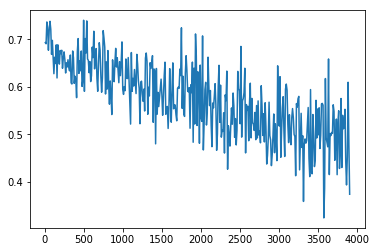

Epoch： 78  start.
Epoch number 78
 Current loss 0.5336475968360901

Epoch number 78
 Current loss 0.378328412771225

Epoch number 78
 Current loss 0.6178451776504517

Epoch number 78
 Current loss 0.37393784523010254

Epoch number 78
 Current loss 0.36978620290756226

Accuracy of the network on the 296 val pairs in F09 : 55 %


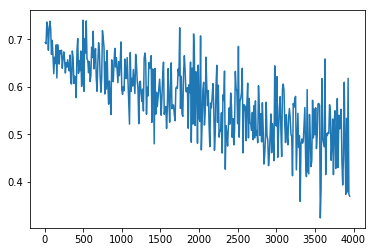

Epoch： 79  start.
Epoch number 79
 Current loss 0.40644824504852295

Epoch number 79
 Current loss 0.5995413661003113

Epoch number 79
 Current loss 0.3906289041042328

Epoch number 79
 Current loss 0.478515088558197

Epoch number 79
 Current loss 0.44545140862464905

Accuracy of the network on the 296 val pairs in F09 : 54 %


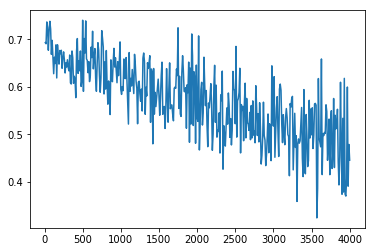

Epoch： 80  start.
Epoch number 80
 Current loss 0.5874319672584534

Epoch number 80
 Current loss 0.4311756491661072

Epoch number 80
 Current loss 0.4573264420032501

Epoch number 80
 Current loss 0.49407535791397095

Epoch number 80
 Current loss 0.47437751293182373

Accuracy of the network on the 296 val pairs in F09 : 56 %


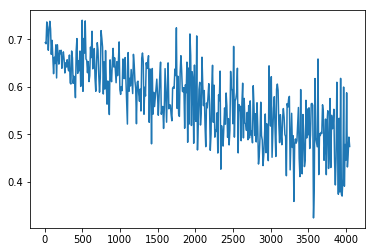

Epoch： 81  start.
Epoch number 81
 Current loss 0.41213929653167725

Epoch number 81
 Current loss 0.4991750419139862

Epoch number 81
 Current loss 0.42390644550323486

Epoch number 81
 Current loss 0.521774411201477

Epoch number 81
 Current loss 0.5176268219947815

Accuracy of the network on the 296 val pairs in F09 : 60 %


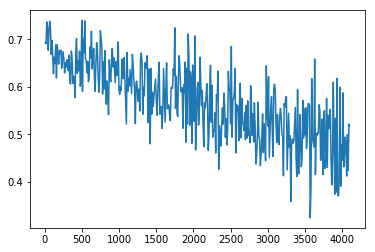

Epoch： 82  start.
Epoch number 82
 Current loss 0.5251960158348083

Epoch number 82
 Current loss 0.5472018122673035

Epoch number 82
 Current loss 0.477301687002182

Epoch number 82
 Current loss 0.5023844838142395

Epoch number 82
 Current loss 0.41282638907432556

Accuracy of the network on the 296 val pairs in F09 : 53 %


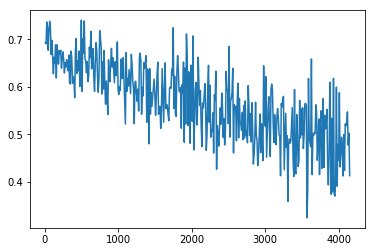

Epoch： 83  start.
Epoch number 83
 Current loss 0.5740681290626526

Epoch number 83
 Current loss 0.4365020990371704

Epoch number 83
 Current loss 0.36747002601623535

Epoch number 83
 Current loss 0.3543885052204132

Epoch number 83
 Current loss 0.4780900478363037

Accuracy of the network on the 296 val pairs in F09 : 53 %


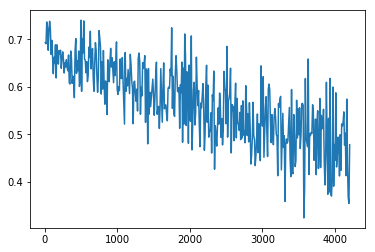

Epoch： 84  start.
Epoch number 84
 Current loss 0.4280890226364136

Epoch number 84
 Current loss 0.4615772068500519

Epoch number 84
 Current loss 0.46908140182495117

Epoch number 84
 Current loss 0.517093300819397

Epoch number 84
 Current loss 0.43668892979621887

Accuracy of the network on the 296 val pairs in F09 : 48 %


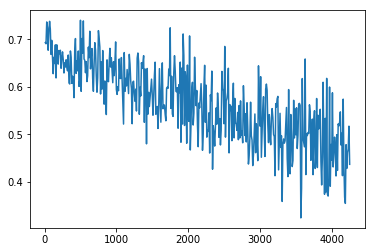

Epoch： 85  start.
Epoch number 85
 Current loss 0.38767310976982117

Epoch number 85
 Current loss 0.4636196494102478

Epoch number 85
 Current loss 0.4845077693462372

Epoch number 85
 Current loss 0.378980815410614

Epoch number 85
 Current loss 0.4725588262081146

Accuracy of the network on the 296 val pairs in F09 : 55 %


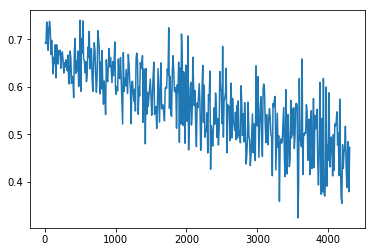

Epoch： 86  start.
Epoch number 86
 Current loss 0.40041598677635193

Epoch number 86
 Current loss 0.4283159673213959

Epoch number 86
 Current loss 0.5660055875778198

Epoch number 86
 Current loss 0.35779279470443726

Epoch number 86
 Current loss 0.4463581442832947

Accuracy of the network on the 296 val pairs in F09 : 54 %


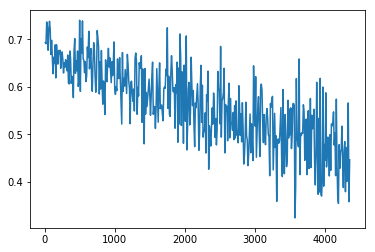

Epoch： 87  start.
Epoch number 87
 Current loss 0.43958964943885803

Epoch number 87
 Current loss 0.4203616678714752

Epoch number 87
 Current loss 0.3813004791736603

Epoch number 87
 Current loss 0.3648827075958252

Epoch number 87
 Current loss 0.3407195210456848

Accuracy of the network on the 296 val pairs in F09 : 50 %


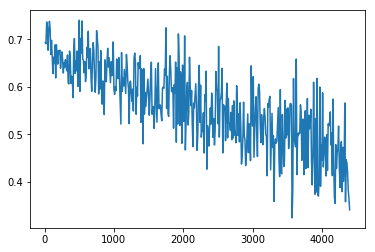

Epoch： 88  start.
Epoch number 88
 Current loss 0.43141090869903564

Epoch number 88
 Current loss 0.4727589786052704

Epoch number 88
 Current loss 0.4478154480457306

Epoch number 88
 Current loss 0.3285524845123291

Epoch number 88
 Current loss 0.47553005814552307

Accuracy of the network on the 296 val pairs in F09 : 54 %


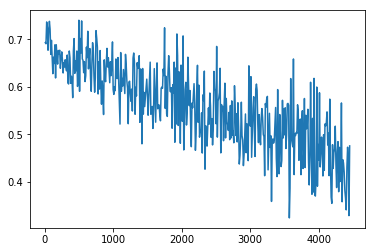

Epoch： 89  start.
Epoch number 89
 Current loss 0.5708973407745361

Epoch number 89
 Current loss 0.4278544485569

Epoch number 89
 Current loss 0.5023558735847473

Epoch number 89
 Current loss 0.4019310176372528

Epoch number 89
 Current loss 0.39693978428840637

Accuracy of the network on the 296 val pairs in F09 : 56 %


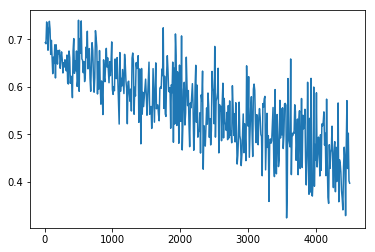

Epoch： 90  start.
Epoch number 90
 Current loss 0.485758513212204

Epoch number 90
 Current loss 0.4365059435367584

Epoch number 90
 Current loss 0.505826473236084

Epoch number 90
 Current loss 0.3672294020652771

Epoch number 90
 Current loss 0.484999418258667

Accuracy of the network on the 296 val pairs in F09 : 54 %


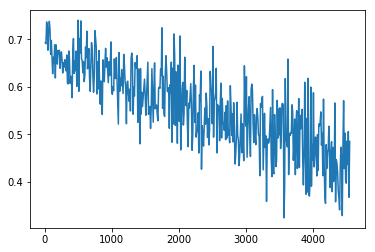

Epoch： 91  start.
Epoch number 91
 Current loss 0.4224415123462677

Epoch number 91
 Current loss 0.5241745710372925

Epoch number 91
 Current loss 0.43859347701072693

Epoch number 91
 Current loss 0.4105636775493622

Epoch number 91
 Current loss 0.4022406041622162

Accuracy of the network on the 296 val pairs in F09 : 55 %


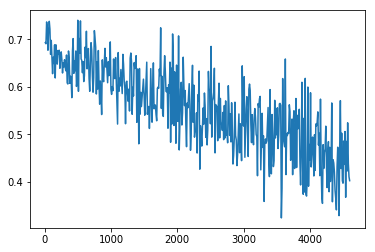

Epoch： 92  start.
Epoch number 92
 Current loss 0.44901618361473083

Epoch number 92
 Current loss 0.44500675797462463

Epoch number 92
 Current loss 0.4663543701171875

Epoch number 92
 Current loss 0.4619394540786743

Epoch number 92
 Current loss 0.41040581464767456

Accuracy of the network on the 296 val pairs in F09 : 55 %


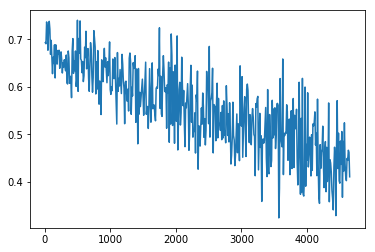

Epoch： 93  start.
Epoch number 93
 Current loss 0.44564321637153625

Epoch number 93
 Current loss 0.40522295236587524

Epoch number 93
 Current loss 0.5127611756324768

Epoch number 93
 Current loss 0.46744203567504883

Epoch number 93
 Current loss 0.4022912383079529

Accuracy of the network on the 296 val pairs in F09 : 57 %


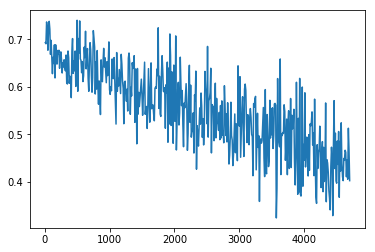

Epoch： 94  start.
Epoch number 94
 Current loss 0.41776660084724426

Epoch number 94
 Current loss 0.5496325492858887

Epoch number 94
 Current loss 0.5506690144538879

Epoch number 94
 Current loss 0.4281170070171356

Epoch number 94
 Current loss 0.396458238363266

Accuracy of the network on the 296 val pairs in F09 : 57 %


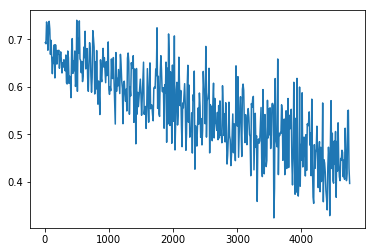

Epoch： 95  start.
Epoch number 95
 Current loss 0.5086830854415894

Epoch number 95
 Current loss 0.414900004863739

Epoch number 95
 Current loss 0.5267875790596008

Epoch number 95
 Current loss 0.4571968615055084

Epoch number 95
 Current loss 0.4212217926979065

Accuracy of the network on the 296 val pairs in F09 : 55 %


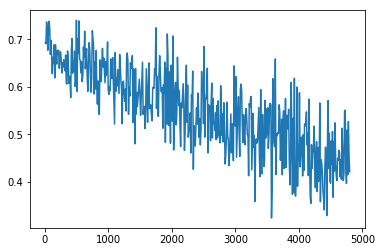

Epoch： 96  start.
Epoch number 96
 Current loss 0.40596088767051697

Epoch number 96
 Current loss 0.5537216067314148

Epoch number 96
 Current loss 0.3238673210144043

Epoch number 96
 Current loss 0.5038480758666992

Epoch number 96
 Current loss 0.52104252576828

Accuracy of the network on the 296 val pairs in F09 : 57 %


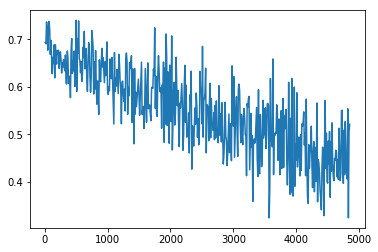

Epoch： 97  start.
Epoch number 97
 Current loss 0.40511804819107056

Epoch number 97
 Current loss 0.4503666162490845

Epoch number 97
 Current loss 0.5082697868347168

Epoch number 97
 Current loss 0.49735909700393677

Epoch number 97
 Current loss 0.49171286821365356

Accuracy of the network on the 296 val pairs in F09 : 55 %


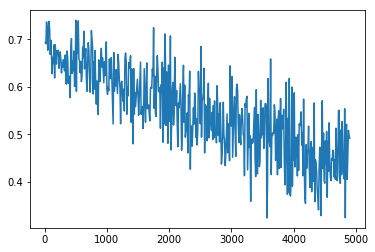

Epoch： 98  start.
Epoch number 98
 Current loss 0.4452210068702698

Epoch number 98
 Current loss 0.4057796895503998

Epoch number 98
 Current loss 0.3862573504447937

Epoch number 98
 Current loss 0.4466998279094696

Epoch number 98
 Current loss 0.5350457429885864

Accuracy of the network on the 296 val pairs in F09 : 50 %


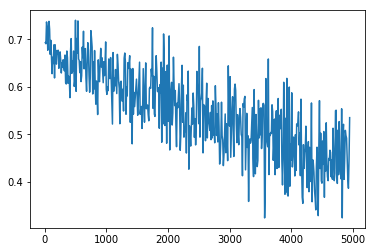

Epoch： 99  start.
Epoch number 99
 Current loss 0.4510032534599304

Epoch number 99
 Current loss 0.3479779362678528

Epoch number 99
 Current loss 0.37651368975639343

Epoch number 99
 Current loss 0.4168757200241089

Epoch number 99
 Current loss 0.4832800030708313

Accuracy of the network on the 296 val pairs in F09 : 54 %


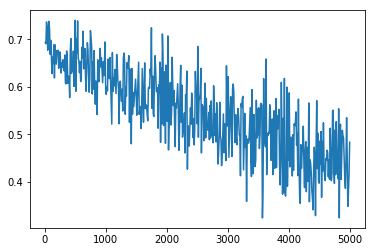

In [10]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :#show changes of loss value after each 10 batches
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
        correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val, 'val pairs in',val_famillies, ': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

In [11]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,transform=None):
        self.test_df = pd.read_csv('../input/sample_submission.csv')#pandas用来读取csv文件
        self.transform = transform
        
    def __getitem__(self,index):
        #data in submission.csv:
        #       img_pair               is_related
        #face05508.jpg-face01210.jpg       0
        #face05820.jpg-face03938.jpg       0
        
        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]
        #print(img0_path,'-',img1_path) #reserved to check whether test data is in order.
        
        img0 = Image.open('../input/test/'+img0_path)
        img1 = Image.open('../input/test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1
    
    def __len__(self):
        return len(self.test_df)

In [12]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [13]:
test_df = pd.read_csv('../input/sample_submission.csv')#pandas用来读取csv文件
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer
        
test_df['is_related'] = predictions
test_df.to_csv("submission.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

,img_pair,is_related
0,face05508.jpg-face01210.jpg,1.0
1,face05750.jpg-face00898.jpg,1.0
2,face05820.jpg-face03938.jpg,1.0
3,face02104.jpg-face01172.jpg,0.0
4,face02428.jpg-face05611.jpg,0.0
5,face01219.jpg-face00274.jpg,1.0
6,face04262.jpg-face00555.jpg,0.0
7,face03697.jpg-face01892.jpg,1.0
8,face03524.jpg-face00319.jpg,1.0
9,face03410.jpg-face05368.jpg,0.0
